# GAT using Tensorflow

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install -q h5py==2.10.0

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## CLI Run

In [ ]:
!git clone https://github.com/shenweichen/GraphNeuralNetwork.git

In [ ]:
%cd GraphNeuralNetwork

/content/GraphNeuralNetwork


In [ ]:
!cd gnn && python run_gat_cora.py

Dataset has 2708 nodes, 5429 edges, 1433 features.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
start training
Train on 2708 samples, validate on 2708 samples
2021-10-11 17:05:57.286617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-11 17:05:57.309128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 17:05:57.309974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2021-10-11 17:05:57.310370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully

## API Exploration

### CORA Dataset

In [ ]:
!mkdir -p /content/data/cora
%cd /content/data/cora
!wget -q --show-progress https://github.com/shenweichen/GraphNeuralNetwork/raw/master/data/cora/cora.content
!wget -q --show-progress https://github.com/shenweichen/GraphNeuralNetwork/raw/master/data/cora/cora.features
!wget -q --show-progress https://github.com/shenweichen/GraphNeuralNetwork/raw/master/data/cora/cora_edgelist.txt
!wget -q --show-progress https://github.com/shenweichen/GraphNeuralNetwork/raw/master/data/cora/cora_labels.txt
!wget -q --show-progress https://github.com/shenweichen/GraphNeuralNetwork/raw/master/data/cora/cora.cites
%cd /content

/content/data/cora
cora.content        100%[===================>]   7.46M  --.-KB/s    in 0.1s    
cora.features       100%[===================>]  14.81M  98.1MB/s    in 0.2s    
cora_edgelist.txt   100%[===================>]  97.30K  --.-KB/s    in 0.01s   
cora_labels.txt     100%[===================>]  17.43K  --.-KB/s    in 0s      
cora.cites          100%[===================>]  68.29K  --.-KB/s    in 0.01s   
/content


### GAT

In [ ]:
from __future__ import absolute_import

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.initializers import Zeros
from tensorflow.python.keras.layers import Layer, Dropout,Input
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.models import Model


class GATLayer(Layer):

    def __init__(self, att_embedding_size=8, head_num=8, dropout_rate=0.5, l2_reg=0, activation=tf.nn.relu,
                 reduction='concat', use_bias=True, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.activation = activation
        self.act = activation
        self.reduction = reduction
        self.use_bias = use_bias
        self.seed = seed
        super(GATLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        X, A = input_shape
        embedding_size = int(X[-1])
        self.weight = self.add_weight(name='weight', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                      dtype=tf.float32,
                                      regularizer=l2(self.l2_reg),
                                      initializer=tf.keras.initializers.glorot_uniform())
        self.att_self_weight = self.add_weight(name='att_self_weight',
                                               shape=[1, self.head_num,
                                                      self.att_embedding_size],
                                               dtype=tf.float32,
                                               regularizer=l2(self.l2_reg),
                                               initializer=tf.keras.initializers.glorot_uniform())
        self.att_neighs_weight = self.add_weight(name='att_neighs_weight',
                                                 shape=[1, self.head_num,
                                                        self.att_embedding_size],
                                                 dtype=tf.float32,
                                                 regularizer=l2(self.l2_reg),
                                                 initializer=tf.keras.initializers.glorot_uniform())

        if self.use_bias:
            self.bias_weight = self.add_weight(name='bias', shape=[1, self.head_num, self.att_embedding_size],
                                               dtype=tf.float32,
                                               initializer=Zeros())
        self.in_dropout = Dropout(self.dropout_rate)
        self.feat_dropout = Dropout(self.dropout_rate, )
        self.att_dropout = Dropout(self.dropout_rate, )
        # Be sure to call this somewhere!
        super(GATLayer, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):

        X, A = inputs
        X = self.in_dropout(X)  # N * D
        # A = self.att_dropout(A, training=training)
        if K.ndim(X) != 2:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 2 dimensions" % (K.ndim(X)))

        features = tf.matmul(X, self.weight, )  # None F'*head_num
        features = tf.reshape(
            features, [-1, self.head_num, self.att_embedding_size])  # None head_num F'

        # attn_for_self = K.dot(features, attention_kernel[0])  # (N x 1), [a_1]^T [Wh_i]
        # attn_for_neighs = K.dot(features, attention_kernel[1])  # (N x 1), [a_2]^T [Wh_j]

        # head_num None F D --- > head_num None(F) D

        # querys = tf.stack(tf.split(querys, self.head_num, axis=1))
        # keys = tf.stack(tf.split(keys, self.head_num, axis=1))#[?,1,1433,64]

        # features = tf.stack(tf.split(features, self.head_num, axis=1))  # head_num None F'
        attn_for_self = tf.reduce_sum(
            features * self.att_self_weight, axis=-1, keep_dims=True)  # None head_num 1
        attn_for_neighs = tf.reduce_sum(
            features * self.att_neighs_weight, axis=-1, keep_dims=True)
        dense = tf.transpose(
            attn_for_self, [1, 0, 2]) + tf.transpose(attn_for_neighs, [1, 2, 0])

        dense = tf.nn.leaky_relu(dense, alpha=0.2)
        mask = -10e9 * (1.0 - A)
        dense += tf.expand_dims(mask, axis=0)  # [?,8,8], [1,?,2708]

        self.normalized_att_scores = tf.nn.softmax(
            dense, dim=-1, )  # head_num None(F) None(F)

        features = self.feat_dropout(features, )
        self.normalized_att_scores = self.att_dropout(
            self.normalized_att_scores)

        result = tf.matmul(self.normalized_att_scores,
                           tf.transpose(features, [1, 0, 2]))  # head_num None F D   [8,2708,8] [8,2708,3]
        result = tf.transpose(result, [1, 0, 2])  # None head_num attsize

        if self.use_bias:
            result += self.bias_weight

        # head_num Node embeding_size
        if self.reduction == "concat":
            result = tf.concat(
                tf.split(result, self.head_num, axis=1), axis=-1)
            result = tf.squeeze(result, axis=1)
        else:
            result = tf.reduce_mean(result, axis=1)

        if self.act:
            result = self.activation(result)

        result._uses_learning_phase = True
        return result

    def compute_output_shape(self, input_shape):
        if self.reduction == "concat":

            return (None, self.att_embedding_size * self.head_num)
        else:
            return (None, self.att_embedding_size)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,
                  'seed': self.seed}
        base_config = super(GATLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))




def GAT(adj_dim,feature_dim,num_class,num_layers=2,n_attn_heads = 8,att_embedding_size=8,dropout_rate=0.0,l2_reg=0.0,use_bias=True):
    X_in = Input(shape=(feature_dim,))
    A_in = Input(shape=(adj_dim,))
    h = X_in
    for _ in range(num_layers-1):
        h = GATLayer(att_embedding_size=att_embedding_size, head_num=n_attn_heads, dropout_rate=dropout_rate, l2_reg=l2_reg,
                                     activation=tf.nn.elu, use_bias=use_bias, )([h, A_in])

    h = GATLayer(att_embedding_size=num_class, head_num=1, dropout_rate=dropout_rate, l2_reg=l2_reg,
                                 activation=tf.nn.softmax, use_bias=use_bias, reduction='mean')([h, A_in])

    model = Model(inputs=[X_in, A_in], outputs=h)

    return model

### Utils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE

import os
import pickle as pkl
import sys


def get_splits(y,):
    idx_list = np.arange(len(y))
    # train_val, idx_test = train_test_split(idx_list, test_size=0.2, random_state=1024)  # 1000
    # idx_train, idx_val = train_test_split(train_val, test_size=0.2, random_state=1024)  # 500

    idx_train = []
    label_count = {}
    for i, label in enumerate(y):
        label = np.argmax(label)
        if label_count.get(label, 0) < 20:
            idx_train.append(i)
            label_count[label] = label_count.get(label, 0) + 1

    idx_val_test = list(set(idx_list) - set(idx_train))
    idx_val = idx_val_test[0:500]
    idx_test = idx_val_test[500:1500]


    y_train = np.zeros(y.shape, dtype=np.int32)
    y_val = np.zeros(y.shape, dtype=np.int32)
    y_test = np.zeros(y.shape, dtype=np.int32)
    y_train[idx_train] = y[idx_train]
    y_val[idx_val] = y[idx_val]
    y_test[idx_test] = y[idx_test]
    train_mask = sample_mask(idx_train, y.shape[0])
    val_mask = sample_mask(idx_val, y.shape[0])
    test_mask = sample_mask(idx_test, y.shape[0])

    return y_train, y_val, y_test,train_mask, val_mask, test_mask


def load_data_v1(dataset="cora", path="data/cora/",):

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    onehot_labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(onehot_labels.shape[0], onehot_labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = convert_symmetric(adj, )

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    y_train, y_val, y_test, train_mask, val_mask, test_mask = get_splits(onehot_labels)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask



def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def load_data(dataset_str):
    """Load data."""
    FILE_PATH = os.path.abspath(__file__)
    DIR_PATH = os.path.dirname(FILE_PATH)
    DATA_PATH = os.path.join(DIR_PATH, 'data/')
    DATA_PATH = "data/cora/"

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("{}ind.{}.{}".format(DATA_PATH, dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("{}ind.{}.test.index".format(DATA_PATH, dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder),
                                    max(test_idx_reorder) + 1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range - min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range - min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + 500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]


    return sp.csr_matrix(adj), features, y_train, y_val, y_test, train_mask, val_mask, test_mask



def sample_mask(idx, l):
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def convert_symmetric(X, sparse=True):
    if sparse:
        X += X.T - sp.diags(X.diagonal())
    else:
        X += X.T - np.diag(X.diagonal())
    return X


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot


def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = sp.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + sp.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj


def plot_embeddings(embeddings, X, Y):

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][:], [])
        color_idx[Y[i][:]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense()

### Main

Epoch 2/5
2708/2708 - 2s - loss: 0.1326 - weighted_categorical_crossentropy: 1.9456 - weighted_acc: 0.1643 - val_loss: 0.3845 - val_weighted_categorical_crossentropy: 1.9364 - val_weighted_acc: 0.3920
Epoch 3/5
2708/2708 - 2s - loss: 0.1275 - weighted_categorical_crossentropy: 1.9457 - weighted_acc: 0.1000 - val_loss: 0.3801 - val_weighted_categorical_crossentropy: 1.9369 - val_weighted_acc: 0.3940
Epoch 4/5
2708/2708 - 2s - loss: 0.1229 - weighted_categorical_crossentropy: 1.9419 - weighted_acc: 0.1571 - val_loss: 0.3763 - val_weighted_categorical_crossentropy: 1.9364 - val_weighted_acc: 0.4020
Epoch 5/5
2708/2708 - 2s - loss: 0.1193 - weighted_categorical_crossentropy: 1.9444 - weighted_acc: 0.1571 - val_loss: 0.3732 - val_weighted_categorical_crossentropy: 1.9362 - val_weighted_acc: 0.4140
2708/2708 [==============================] - 1s 200us/sample - loss: 0.7323 - weighted_categorical_crossentropy: 1.9405 - weighted_acc: 0.3230
Done.
Test loss: 0.7323194146156311
Test weighted_los

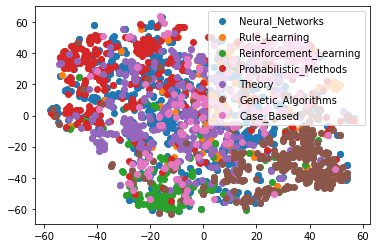

In [ ]:
from __future__ import division

import scipy.sparse as sp
import  numpy as np

from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import Adam

# from gat import GAT
# from utils import plot_embeddings,load_data_v1

if __name__ == "__main__":
    # Read data

    FEATURE_LESS = False

    A, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data_v1(
        'cora')

    A = A + sp.eye(A.shape[0])
    features /= features.sum(axis=1, ).reshape(-1, 1)

    model = GAT(adj_dim=A.shape[0], feature_dim=features.shape[1], num_class=y_train.shape[1], num_layers=2,
                n_attn_heads=8, att_embedding_size=8,
                dropout_rate=0.6, l2_reg=2.5e-4, use_bias=True)
    optimizer = Adam(lr=0.005)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])

    model_input = [features, A.toarray()]

    val_data = (model_input, y_val, val_mask)

    mc_callback = ModelCheckpoint('./best_model.h5',
                                  monitor='val_weighted_categorical_crossentropy',
                                  save_best_only=True,
                                  save_weights_only=True)

    print("start training")
    model.fit(model_input, y_train, sample_weight=train_mask, validation_data=val_data,
              batch_size=A.shape[0], epochs=5, shuffle=False, verbose=2,
              callbacks=[mc_callback])
    # test
    model.load_weights('./best_model.h5')
    eval_results = model.evaluate(
        model_input, y_test, sample_weight=test_mask, batch_size=A.shape[0])

    print('Done.\n'
          'Test loss: {}\n'
          'Test weighted_loss: {}\n'
          'Test accuracy: {}'.format(*eval_results))

    gcn_embedding = model.layers[-1]
    embedding_model = Model(model.input, outputs=Lambda(lambda x: gcn_embedding.output)(model.input))
    embedding_weights = embedding_model.predict(model_input, batch_size=A.shape[0])
    y = np.genfromtxt("{}{}.content".format('data/cora/', 'cora'), dtype=np.dtype(str))[:, -1]
    plot_embeddings(embedding_weights, np.arange(A.shape[0]), y)